## Load configs and read data

In [1]:
from nltk.corpus import stopwords   
from stop_words import safe_get_stop_words
from pathlib import Path
import numpy as np  
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import ujson
import pickle
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer

In [2]:
run_config = ujson.load(open('run_config.json','r'))
mapping = ujson.load(open('mappings.json','r'))[run_config['language']]

In [3]:
if run_config['debug_mode']:
    data = pd.read_csv(mapping['dataset_file'],
                       nrows=mapping['debug_dataset_size']).dropna()
else:
    data = pd.read_csv(mapping['dataset_file']).dropna()

In [4]:
if run_config['samples_order'] == 'matches_first':
    matches = data[data[f'cleaned_{mapping["summaries_column"]}']==data[f'cleaned_alternative_{mapping["summaries_column"]}']]
    not_matches = data[data[f'cleaned_{mapping["summaries_column"]}']!=data[f'cleaned_alternative_{mapping["summaries_column"]}']]
    data = pd.concat([not_matches, matches], axis=0)
elif run_config['samples_order'] == 'matches_last':
    matches = data[data[f'cleaned_{mapping["summaries_column"]}']==data[f'cleaned_alternative_{mapping["summaries_column"]}']]
    not_matches = data[data[f'cleaned_{mapping["summaries_column"]}']!=data[f'cleaned_alternative_{mapping["summaries_column"]}']]
    data = pd.concat([matches, not_matches], axis=0)
elif run_config['samples_order'] == 'random':
    data = data.sample(frac = 1)

In [5]:
data.head()

id                                       cleaned_text  \
0  173493  україну ввезено жодної книги росії повідомили ...   
1  173494  голова національної поліції україни сергій кня...   
2  173495  комітет верховної ради питань запобігання прот...   
3  173496  представник німецького уряду заявив німеччина ...   
4  173497  березні анатолій тимощук роки підписав контрак...   

                                       cleaned_title  \
0  _START_ україну не ввезли жодної книги росії р...   
1  _START_ нацполіції готуються до можливих прово...   
2  _START_ антикорупційний комітет ради оголосив ...   
3  _START_ німеччина вважає росію та іран відпові...   
4  _START_ тимощук назвав зеніт найкращим варіант...   

                           cleaned_alternative_title  
0  _START_ україну не ввезли жодної книги росії р...  
1  _START_ нацполіції готуються до можливих прово...  
2  _START_ антикорупційний комітет ради оголосив ...  
3  _START_ німеччина вважає росію та іран відпові...  
4  _START_ тимощук назвав зеніт найкращим варіант...

## Cleaned texts and summaries analysis

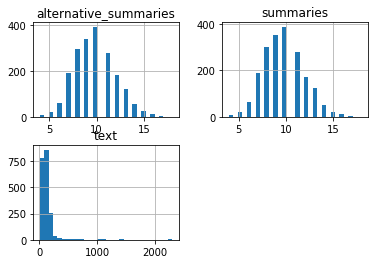

In [6]:
import matplotlib.pyplot as plt
text_word_count = []
summaries_word_count = []
alternative_summaries_word_count = []

for i in data[f'cleaned_{mapping["text_column"]}']:
      text_word_count.append(len(i.split()))

for i in data[f'cleaned_{mapping["summaries_column"]}']:
      summaries_word_count.append(len(i.split()))
        
for i in data[f'cleaned_alternative_{mapping["summaries_column"]}']:
      alternative_summaries_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count,
                          'summaries':summaries_word_count,
                          'alternative_summaries':alternative_summaries_word_count})
length_df.hist(bins = 30)
plt.show()

In [7]:
max_len_text = run_config['max_len_text']
max_len_summaries = run_config['max_len_summaries']

In [8]:
valid_train_samples_fraction = length_df[(length_df['text'] <= max_len_text)\
                                         &(length_df['summaries'] <= max_len_summaries)\
                                         &(length_df['alternative_summaries'] <= max_len_summaries)].shape[0] / data.shape[0]
valid_train_samples_fraction

0.893

## Split dataset, prepare tokenizers, pad sequences

In [9]:
if run_config['loss_function'] == 'custom':
    label_cols = [f'cleaned_{mapping["summaries_column"]}',f'cleaned_alternative_{mapping["summaries_column"]}']
elif run_config['loss_function'] == 'common':
    label_cols = f'cleaned_{mapping["summaries_column"]}'

In [10]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(data[f'cleaned_{mapping["text_column"]}'],
                                            data[label_cols],
                                            test_size=0.1,
                                            random_state=0,
                                            shuffle=True)

In [11]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [12]:
y_tokenizer = Tokenizer()

if run_config['loss_function']=='custom':
    #preparing a tokenizer for summary on training data 
    y_tokenizer.fit_on_texts(list(y_tr['cleaned_title'])+list(y_tr['cleaned_alternative_title']))

    #convert summary sequences into integer sequences
    y_tr['cleaned_title'] = y_tokenizer.texts_to_sequences(y_tr['cleaned_title'])
    y_tr['cleaned_alternative_title'] = y_tokenizer.texts_to_sequences(y_tr['cleaned_alternative_title'])
    y_val['cleaned_title'] = y_tokenizer.texts_to_sequences(y_val['cleaned_title'])
    y_val['cleaned_alternative_title'] = y_tokenizer.texts_to_sequences(y_val['cleaned_alternative_title'])

    #padding zero upto maximum length
    y_tr_ct = pad_sequences(y_tr['cleaned_title'], maxlen=max_len_summaries, padding='post')
    y_tr_cat = pad_sequences(y_tr['cleaned_alternative_title'], maxlen=max_len_summaries, padding='post')
    y_val_ct = pad_sequences(y_val['cleaned_title'], maxlen=max_len_summaries, padding='post')
    y_val_cat = pad_sequences(y_val['cleaned_alternative_title'], maxlen=max_len_summaries, padding='post')

    #y_tr['cleaned_title'] = pd.Series([y_tr_ct[index,:] for index in range(y_tr_ct.shape[0])], index=y_tr.index)
    #y_tr['cleaned_alternative_title'] = pd.Series([y_tr_cat[index,:] for index in range(y_tr_cat.shape[0])], index=y_tr.index)
    #y_val['cleaned_title'] = pd.Series([y_val_ct[index,:] for index in range(y_val_ct.shape[0])], index=y_val.index)
    #y_val['cleaned_alternative_title'] = pd.Series([y_val_cat[index,:] for index in range(y_val_cat.shape[0])], index=y_val.index)
    
elif run_config['loss_function']=='common':
    #preparing a tokenizer for summary on training data 
    y_tokenizer.fit_on_texts(list(y_tr))

    #convert summary sequences into integer sequences
    y_tr = y_tokenizer.texts_to_sequences(y_tr)
    y_val = y_tokenizer.texts_to_sequences(y_val)

    #padding zero upto maximum length
    y_tr = pad_sequences(y_tr, maxlen=max_len_summaries, padding='post')
    y_val = pad_sequences(y_val, maxlen=max_len_summaries, padding='post')
    
y_voc_size  =   len(y_tokenizer.word_index) + 1

### Models

In [13]:
from tensorflow.keras import backend as K 
import tensorflow as tf
K.clear_session() 
latent_dim = run_config['latent_dim']

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     4270900     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 100), ( 80400       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [14]:
def custom_loss_1(y_actual,y_pred):
    loss = K.sparse_categorical_crossentropy(target = y_actual[:,:max_len_summaries-1],
                                             output = y_pred)
    alternative_loss = K.sparse_categorical_crossentropy(target = y_actual[:,max_len_summaries-1:2*(max_len_summaries-1)],
                                                         output = y_pred)
    return tf.minimum(loss, alternative_loss)

def custom_loss_2(y_actual,y_pred):
    loss = K.sparse_categorical_crossentropy(target = y_actual[:,:max_len_summaries-1],
                                             output = y_pred)
    if tf.math.equal(y_actual[:,:max_len_summaries-1], y_actual[:,max_len_summaries-1:2*(max_len_summaries-1)]):
        alternative_loss = K.sparse_categorical_crossentropy(target = y_actual[:,max_len_summaries-1:2*(max_len_summaries-1)],
                                                             output = y_pred)
        return tf.minimum(loss, alternative_loss)
    else:
        return loss

In [15]:
if run_config['loss_function'] == 'common':
    loss = 'sparse_categorical_crossentropy'
elif run_config['loss_function'] == 'custom':
    loss = custom_loss_1

model.compile(optimizer='rmsprop',
              loss=loss)

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

### Training

In [17]:
current_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
run_dir = Path(f'run/{current_datetime}')

In [18]:
model_params = {'epochs':run_config['epochs'], 'callbacks':[es], 'batch_size':run_config['batch_size']}
if run_config['loss_function'] == 'common':
    model_params.update({'x':[x_tr,y_tr[:,:-1]],
                         'y':y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                         'validation_data':([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])})
elif run_config['loss_function'] == 'custom':
    model_params.update({'x':[x_tr, y_tr_ct[:,:-1]],
                         'y':np.hstack([y_tr_ct.reshape(y_tr_ct.shape[0],y_tr_ct.shape[1], 1)[:,1:],
                                        y_tr_cat.reshape(y_tr_cat.shape[0],y_tr_cat.shape[1], 1)[:,1:]]),
                         'validation_data':([x_val,
                                             y_val_ct[:,:-1]],
                                            np.hstack([y_val_ct.reshape(y_val_ct.shape[0],y_val_ct.shape[1], 1)[:,1:],
                                                       y_val_cat.reshape(y_val_cat.shape[0],y_val_cat.shape[1], 1)[:,1:]]))})
    
history=model.fit(**model_params)

model.save(run_dir / 'model')
pickle.dump(history.history, open(run_dir / 'history.pickle','wb'))

Epoch 1/5
15/15 [==============================] - 31s 2s/step - loss: 6.6928 - val_loss: 3.6281
Epoch 2/5
15/15 [==============================] - 28s 2s/step - loss: 4.9542 - val_loss: 3.4087
Epoch 3/5
15/15 [==============================] - 27s 2s/step - loss: 4.8376 - val_loss: 3.3469
Epoch 4/5
15/15 [==============================] - 27s 2s/step - loss: 4.7372 - val_loss: 3.5563
Epoch 00004: early stopping
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: run/2020_09_27_11_11_23/model/assets


### Inference

In [19]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [20]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [21]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summaries-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [22]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [23]:
titles = []
predicted_titles = []

for i in range(len(x_val)):
    if run_config['loss_function'] == 'custom':
        titles.append(seq2summary(y_val_ct[i]))
    elif run_config['loss_function'] == 'common':
        titles.append(seq2summary(y_val[i]))
    predicted_titles.append(decode_sequence(x_val[i].reshape(1,max_len_text)))

In [24]:
model_outputs = pd.DataFrame([titles,
                              predicted_titles]).T
model_outputs.columns = ['title', 'predicted_title']
model_outputs.to_csv(run_dir / 'outputs.csv', index=False)

In [25]:
ujson.dump(run_config, open(run_dir / 'run_config.json','w'))